In [1]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats

import sys
sys.path.append("../")
import hmrf_gmm

# 1-D Example Data

## Create Model

In [2]:
phys_space = np.random.randn(500,1)
feat_space = np.random.randn(500,3)

# np.random.seed(12345)
# define domain
latent_1D = np.zeros_like(phys_space[:,0])
dist = scipy.stats.bernoulli(0.01)
dist2 = scipy.stats.bernoulli(0.45)

In [3]:
val = 0
for i in range(len(phys_space[:,0])):
    if dist.rvs():
        if  dist2.rvs():
            val = 2 - val
        else:
            val = 1 - val
    latent_1D[i] = val

In [4]:
latent_1D = np.ones(25)*2
latent_1D = np.append(latent_1D, np.ones(75)*0)
latent_1D = np.append(latent_1D, np.ones(100)*1)
latent_1D = np.append(latent_1D, np.ones(50)*2)
latent_1D = np.append(latent_1D, np.ones(25)*1)
latent_1D = np.append(latent_1D, np.ones(25)*2)
latent_1D = np.append(latent_1D, np.ones(100)*0)
latent_1D = np.append(latent_1D, np.ones(100)*2)

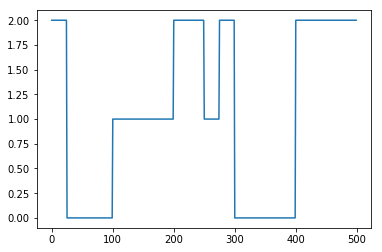

In [5]:
plt.plot(latent_1D);

In [6]:
i = 4
c1 = scipy.stats.multivariate_normal([7,9,10,2.7], np.eye(i)*0.35)
c2 = scipy.stats.multivariate_normal([8,8,9.5,2], np.eye(i)*0.55)
c3 = scipy.stats.multivariate_normal([8,9,9,1.5], np.eye(i)*0.25)
#c4 = scipy.stats.multivariate_normal([8,10,9,4], np.eye(i)*0.25)

## Sample Data

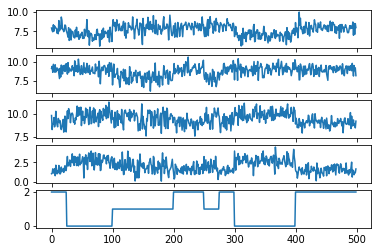

In [7]:
obs = np.empty((len(phys_space[:,0]), 4))

for i,l in enumerate(latent_1D):
    # generate a 2-d random vector at each point
    if l == 0:
        obs[i,:] = c1.rvs()
    elif l == 1:
        obs[i,:] = c2.rvs()
    elif l == 2:
        obs[i,:] = c3.rvs()
        
fig, ax = plt.subplots(5,1)
ax[0].plot(obs[:,0])
ax[1].plot(obs[:,1])
ax[2].plot(obs[:,2])
ax[3].plot(obs[:,3])
ax[4].plot(latent_1D)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


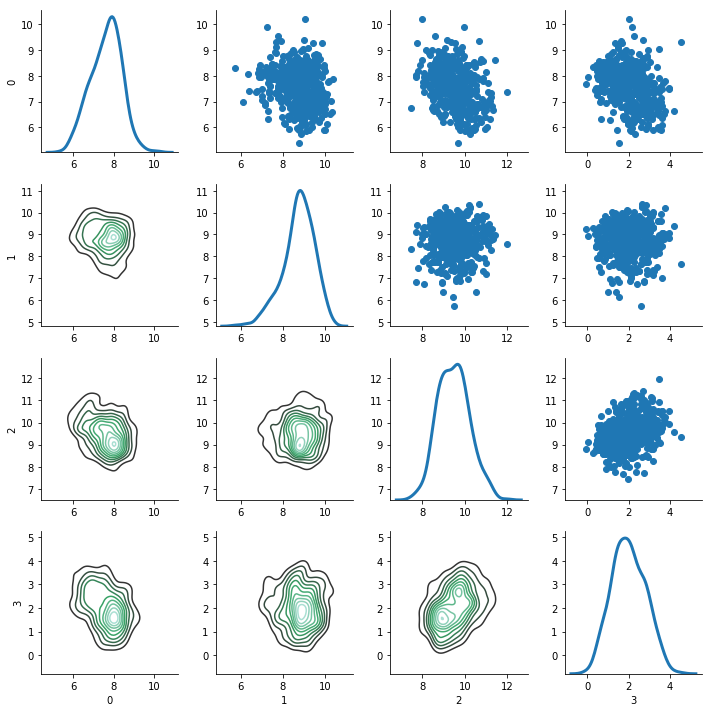

In [71]:
import seaborn as sns
df = pd.DataFrame(obs)

g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

plt.tight_layout()
#plt.savefig("features.png")

In [73]:
def find_correct_labels(gmm, obs, verbose=True):
    """Create look-up table for which label of the GMM belongs to which label in the observations."""
    gmm_means = np.mean(gmm.means_, axis=0)
    obs_means = np.mean(obs, axis=0)
    if verbose:
        print("mean gmm:", gmm_means)
        print("mean obs:", obs_means)
    
    lot = {}
    for o in range(len(obs[1])):
        lot[o] = np.argmin(np.abs(a[o]-b))
        
    return lot

In [78]:
find_correct_labels(ex1.gmm, obs)

mean gmm: [ 7.61823996  8.6433601   9.51916583  2.07357111]
mean obs: [ 7.61430093  8.74595431  9.48548389  2.00867961]


{0: 0, 1: 1, 2: 2, 3: 3}

5.38s/it

In [12]:
ex1 = hmrf_gmm.HMRFGMM(phys_space, obs, n_labels=3, beta_init=10)

In [17]:
ex1.fit(200, beta_jump_length=10, verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [00:26<00:00,  7.50it/s]


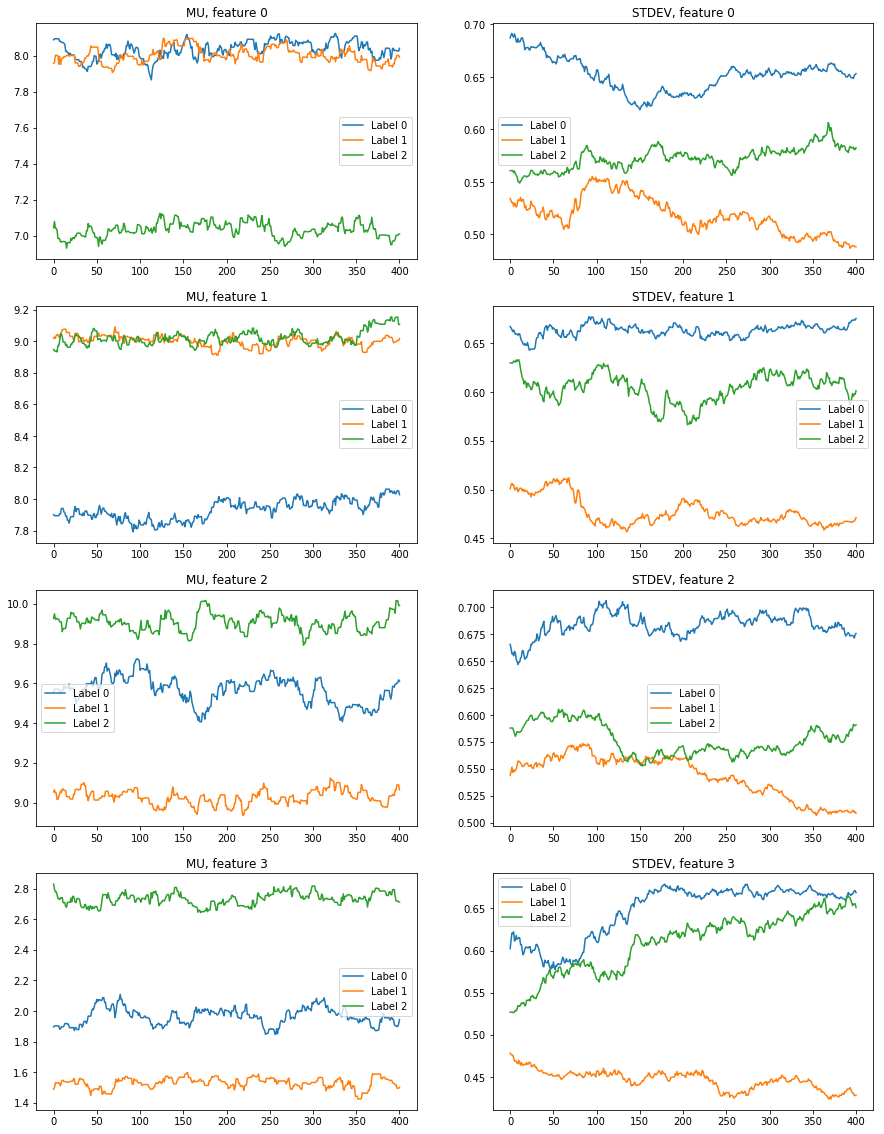

In [19]:
ex1.plot_mu_stdev()
# ex1.plot_mu_stdev()
# plt.tight_layout()
# plt.savefig("mu_stdev.png")

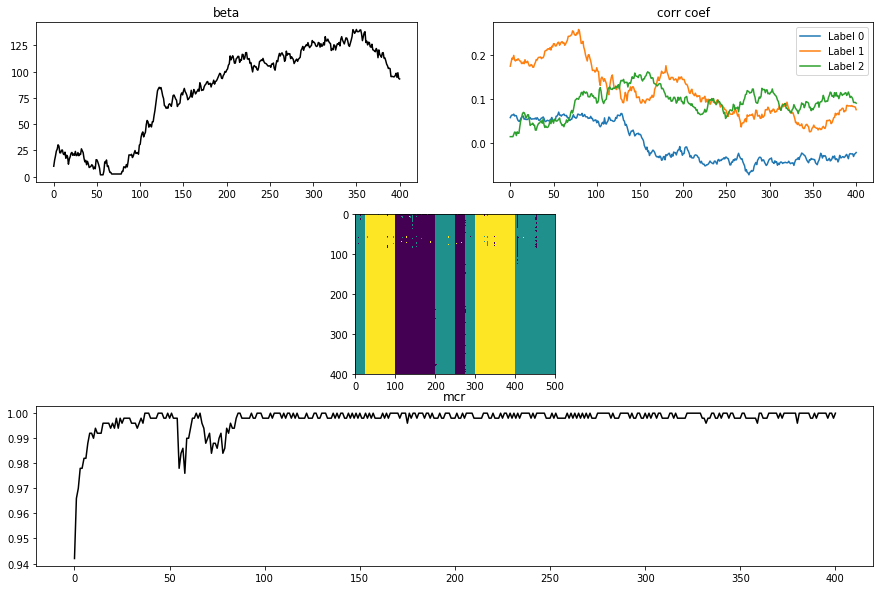

In [18]:
ex1.diagnostics_plot(true_labels=latent_1D)
#plt.tight_layout()
#plt.savefig("diagn.png")

In [20]:
import pickle

In [27]:
import os, sys

In [29]:
pickle.dump(ex1, open( "example.p", "wb" ))

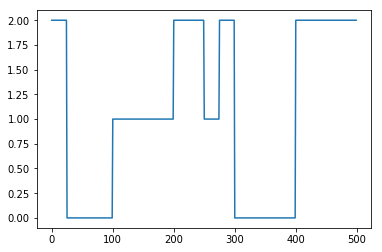

In [16]:
plt.plot(latent_1D)

In [431]:
import numpy as np
from sklearn import mixture
from scipy.stats import multivariate_normal, norm
from copy import copy
from itertools import combinations
import tqdm  # progress bar
import matplotlib.pyplot as plt
from matplotlib import gridspec  # plot arrangements

# VECTORIZE

In [47]:
import numpy as np
from sklearn import mixture
from scipy.stats import multivariate_normal, norm
from copy import copy
from itertools import combinations
import tqdm  # progress bar
import matplotlib.pyplot as plt
from matplotlib import gridspec  # plot arrangements

In [35]:
def calc_labels_prob(te, t):
    """"Calculate labels probability for array of total energies (te) and totally arbitrary skalar value t."""
    return (np.exp(-te/t).T / np.sum(np.exp(-te/t), axis=1)).T

In [36]:
energy_like = ex1.calc_energy_like(ex1.mus[-1], ex1.covs[-1])

# 2 - calculate gibbs/mrf energy
gibbs_energy = ex1.calc_gibbs_energy(ex1.labels[-1], ex1.betas[-1])

# 3 - self energy
self_energy = np.zeros(ex1.n_labels)
# 5 - calculate total energy
total_energy = energy_like + self_energy + gibbs_energy


In [38]:
labels_prob = calc_labels_prob(total_energy, 1.)

In [40]:
gibbs_energy = ex1.calc_gibbs_energy(ex1.labels[-1], ex1.betas[-1])

In [41]:
energy_for_comp_coef = gibbs_energy + self_energy

In [42]:
comp_coef = calc_labels_prob(energy_for_comp_coef, 1.)

In [43]:
comp_coef

array([[  5.00000000e-01,   5.00000000e-01,   1.86298733e-20],
       [  5.00000000e-01,   5.00000000e-01,   6.94144356e-40],
       [  5.00000000e-01,   5.00000000e-01,   6.94144356e-40],
       ..., 
       [  3.72597465e-20,   3.72597465e-20,   1.00000000e+00],
       [  3.72597465e-20,   3.72597465e-20,   1.00000000e+00],
       [  1.86298733e-20,   5.00000000e-01,   5.00000000e-01]])

In [51]:
calc_sum_log_mixture_density_loop(ex1, comp_coef, ex1.mus[-1], ex1.covs[-1])

-2860.5298410769069

In [84]:
calc_sum_log_mixture_density(ex1, comp_coef, ex1.mus[-1], ex1.covs[-1])

-2860.5298410769037

In [83]:
def calc_sum_log_mixture_density(self, comp_coef, mu, cov):
    """
    Calculate sum of log mixture density with each observation at every element.
    :param comp_coef: Component coefficient.
    :param mu: Mean matrix
    :param cov: Covariance matrix
    :return: summed log mixture density of the system
    """
    lmd = np.zeros((500, 3))

    for l in range(self.n_labels):
        draw = multivariate_normal(mean=mu[l, :], cov=cov[l, :, :]).pdf(self.obs)
        # print(np.shape(lmd[:,l]))
        multi = comp_coef[:,l] * draw
        lmd[:,l] = multi
    lmd = np.sum(lmd, axis=1)
    lmd = np.log(lmd)

    return np.sum(lmd)

In [45]:
def calc_sum_log_mixture_density_loop(self, comp_coef, mu, cov):
    """
    Calculate sum of log mixture density with each observation at every element.
    :param comp_coef: Component coefficient.
    :param mu: Mean matrix
    :param cov: Covariance matrix
    :return: summed log mixture density of the system
    """
    if self.dim == 1:
        lmd = 0.

        for x in range(len(self.coords)):
            storage2 = []
            for l in range(self.n_labels):
                a = comp_coef[x, l] * multivariate_normal(mean=mu[l, :], cov=cov[l, :, :]).pdf(self.obs[x])
                # print(a)
                storage2.append(a)

            lmd += (np.log(np.sum(storage2)))

    else:
        pass
    # TODO: 2-dimensional log mixture density
    # TODO: 3-dimensional log mixture density

    return lmd

In [662]:
def calc_energy_like(self, mu, cov):
    """
    Calculates the energy likelihood of the system.
    :param mu: Mean values
    :param cov: Covariance matrix
    :return:
    """

    energy_like_labels = np.zeros((len(self.coords), self.n_labels))
    if self.dim == 1:
        for x in range(len(self.coords)):
            for l in  range(self.n_labels):
                energy_like_labels[x, l] = 0.5 * np.array([self.obs[x] - mu[l, :]]) @ np.linalg.inv(cov[l, :, :]) @ np.array([self.obs[x] - mu[l, :]]).T + 0.5 * np.log(np.linalg.det(cov[l, :, :]))

    else:
        pass
    # TODO: 2-dimensional calculation of energy likelihood labels
    # TODO: 3-dimensional calculation of energy likelihood labels

    return energy_like_labels

In [663]:
%%timeit
calc_energy_like(ex1, ex1.mus[-1], ex1.covs[-1])

83.6 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [664]:
calc_energy_like(ex1, ex1.mus[-1], ex1.covs[-1])

array([[ 6.97370825,  2.51827606, -0.73543508],
       [ 7.96781126,  2.31840325,  0.16633528],
       [ 4.43398377,  0.46495472, -2.08410872],
       ..., 
       [ 5.58174844,  1.19192811, -1.52087527],
       [ 3.12725687, -0.03945506, -0.09542283],
       [ 2.01260336, -0.31394026,  0.36477667]])

In [699]:
def calc_energy_like_vect(self, mu, cov):
    """
    Calculates the energy likelihood of the system.
    :param mu: Mean values
    :param cov: Covariance matrix
    :return:
    """
    energy_like_labels = np.zeros((len(self.coords), self.n_labels))
    for l in  range(self.n_labels):
        a = 0.5 * np.array([self.obs - mu[l, :]]) @ np.linalg.inv(cov[l, :, :])
        print(np.shape(a))
        b = np.array([self.obs - mu[l, :]]).T + 0.5 * np.log(np.linalg.det(cov[l, :, :]))
        print(np.shape(b))
        print(np.shape(energy_like_labels))
        #energy_like_labels[:, l] = a @ b

        return a, b

In [702]:
a

array([[[ 1.4236426 ,  0.10976055, -2.2961096 , -2.13152875],
        [ 2.73083104,  0.9017394 , -1.85091085, -1.54844824],
        [ 2.18762775,  0.17160836, -1.02111122, -1.87913066],
        ..., 
        [ 1.68416169, -0.36915301, -0.84709492, -2.70689491],
        [ 1.99497958, -0.31877054,  0.20860827, -1.97599573],
        [ 2.2091481 , -0.1337791 ,  0.32536153, -1.17241962]]])

In [728]:
c = np.zeros((4,500))
for i in range(4):
    c[i,:] = np.ravel(b[i])

In [741]:
a[:,0]

array([[ 1.4236426 ,  0.10976055, -2.2961096 , -2.13152875]])

In [742]:
c[:,0]

array([-1.11201949, -2.02163635, -4.00885518, -3.59967005])

In [744]:
a @ c

array([[[ 15.07255682,  14.63836652,  12.97213881, ...,  13.37601503,
          10.5321569 ,   9.30350069],
        [  8.1342098 ,   9.56250311,   7.21194189, ...,   6.61543953,
           4.71933517,   4.16743031],
        [  8.07812296,   8.82208276,   7.63881649, ...,   7.77853993,
           6.28953225,   5.4725617 ],
        ..., 
        [ 12.01328189,  11.75686312,  11.30982265, ...,  12.31786388,
          10.41358687,   8.99768481],
        [  4.70263422,   5.39396921,   5.35402541, ...,   5.94679732,
           5.39658276,   4.57217843],
        [  0.72983344,   2.09791978,   1.7929103 , ...,   1.78675069,
           1.82803386,   1.53778468]]])

In [737]:
np.shape(k)

(1, 500, 500)

In [716]:
a,b = calc_energy_like_vect(ex1, ex1.mus[-1], ex1.covs[-1])

(1, 500, 4)
(4, 500, 1)
(500, 3)


In [688]:
%debug

> <ipython-input-686-9d5b1cd81159>(14)calc_energy_like_vect()
     12         b = np.array([self.obs - mu[l, :]]).T + 0.5 * np.log(np.linalg.det(cov[l, :, :]))
     13         print(b)
---> 14         energy_like_labels[:, l] = a @ b
     15 
     16 

ipdb> exit


In [357]:
g[0, ex1.labels[-1][neighborhood[0,0].astype("int64")]]

1.5

In [356]:
gibbs_energy

array([[ 0. ,  0. ,  1.5],
       [ 0. ,  0. ,  1. ],
       [ 0. ,  0. ,  1. ],
       ..., 
       [ 0. ,  0. ,  1. ],
       [ 0. ,  0. ,  1. ],
       [ 0. ,  0. ,  1.5]])

In [355]:
gibbs_energy = calc_gibbs_energy_vect(ex1, ex1.labels[-1], 0.5)

# COV PROPOSAL TESTS

In [18]:
0.45**(1/2)

0.6708203932499369

In [38]:
cov = np.array([[[  1.99561992e+01 , -1.45150996e+00 , -2.63756395e+00  , 6.96056263e+00,    -1.01622760e+00],
  [ -1.45150996e+00 ,  1.17306877e-01  , 1.34722716e-01 , -6.38203391e-01,     8.36635998e-02],
  [ -2.63756395e+00 ,  1.34722716e-01 ,  6.40140987e+00 ,  1.07719128e+00,     2.09006538e-01],
  [  6.96056263e+00,  -6.38203391e-01 ,  1.07719128e+00 ,  4.75785818e+00,    -5.04168206e-01],
  [ -1.01622760e+00 ,  8.36635998e-02 ,  2.09006538e-01  ,-5.04168206e-01,     1.21996211e-01]]])

In [39]:
np.shape(cov)

(1, 5, 5)

In [ ]:
c1 = scipy.stats.multivariate_normal([6,9,10], np.eye(3)*0.25)
c2 = scipy.stats.multivariate_normal([8,8,11], np.eye(3)*0.15)
c3 = scipy.stats.multivariate_normal([8,11,9], np.eye(3)*0.35)

In [55]:
0.25**(1/2)

0.5

In [32]:
cov = np.array([[[ 1.70240204,  0.13019169,  0.26507972, -0.05779667],
 [ 0.13019169,  1.70098472, -0.06757848,  0.07736503],
 [ 0.26507972, -0.06757848,  1.60775912, -0.22083958],
 [-0.05779667 , 0.07736503, -0.22083958,  1.99746643]]])

In [33]:
np.shape(cov)

(1, 4, 4)

In [33]:
np.linalg.svd(cov[0, :, :])

(array([[-0.34658954,  0.68413653,  0.25486621, -0.58896189],
        [ 0.10536204,  0.58889702, -0.74277933,  0.30062935],
        [-0.48871925,  0.23117566,  0.41103607,  0.73400317],
        [ 0.79368005,  0.36292605,  0.46300262,  0.15487163]]),
 array([ 2.16896074,  1.87338189,  1.64548441,  1.32078527]),
 array([[-0.34658954,  0.10536204, -0.48871925,  0.79368005],
        [ 0.68413653,  0.58889702,  0.23117566,  0.36292605],
        [ 0.25486621, -0.74277933,  0.41103607,  0.46300262],
        [-0.58896189,  0.30062935,  0.73400317,  0.15487163]]))

In [47]:
cov = np.array([[[ 3.,  0.2,  0.3],
       [ 0.2,  2.,  0.6],
       [ 0.3,  0.6,  4.]]])

In [48]:
np.shape(cov)

(1, 3, 3)

In [49]:
covdiff = cov - propose_cov(cov, 3,1, 0.00005, 0.0005)
covdiff

 shp v_l: (3, 3)
 shp d_l: (3,)


array([[[-0.00590155,  0.03395092,  0.03608643],
        [ 0.03395092, -0.00803107, -0.00943427],
        [ 0.03608643, -0.00943427,  0.00324243]]])

In [24]:
from itertools import combinations
from scipy.stats import multivariate_normal

In [50]:
cov = np.array([[[ 1.70240204,  0.13019169,  0.26507972, -0.05779667],
 [ 0.13019169,  1.70098472, -0.06757848,  0.07736503],
 [ 0.26507972, -0.06757848,  1.60775912, -0.22083958],
 [-0.05779667 , 0.07736503, -0.22083958,  1.99746643]]])

covdiff = cov - propose_cov(cov, 4,1, 0.00005, 0.0005)
covdiff

 shp v_l: (4, 4)
 shp d_l: (4,)


array([[[-0.00331711, -0.01200307, -0.00910957, -0.00063114],
        [-0.01200307, -0.00658348, -0.00219675, -0.00707097],
        [-0.00910957, -0.00219675, -0.00494187, -0.01065656],
        [-0.00063114, -0.00707097, -0.01065656,  0.01388612]]])

In [61]:
cov = np.array([[[  1.99561992e+01 , -1.45150996e+00 , -2.63756395e+00  , 6.96056263e+00,    -1.01622760e+00],
  [ -1.45150996e+00 ,  1.17306877e-01  , 1.34722716e-01 , -6.38203391e-01,     8.36635998e-02],
  [ -2.63756395e+00 ,  1.34722716e-01 ,  6.40140987e+00 ,  1.07719128e+00,     2.09006538e-01],
  [  6.96056263e+00,  -6.38203391e-01 ,  1.07719128e+00 ,  4.75785818e+00,    -5.04168206e-01],
  [ -1.01622760e+00 ,  8.36635998e-02 ,  2.09006538e-01  ,-5.04168206e-01,     1.21996211e-01]]])

covdiff = cov - propose_cov(cov, 5,1, 0.000000005, 0.00000005)
covdiff

 shp v_l: (5, 5)
 shp d_l: (5,)


array([[[ -1.32504532e-03,  -3.31717970e-03,   1.94099542e-03,
           3.16929509e-04,   1.27308342e-03],
        [ -3.31717970e-03,   4.97891541e-04,  -3.76669214e-04,
          -1.40158481e-03,   9.95005537e-05],
        [  1.94099542e-03,  -3.76669214e-04,   1.46475731e-03,
          -2.43689538e-04,  -3.20029701e-03],
        [  3.16929509e-04,  -1.40158481e-03,  -2.43689538e-04,
          -2.56884675e-04,  -6.19464331e-04],
        [  1.27308342e-03,   9.95005537e-05,  -3.20029701e-03,
          -6.19464331e-04,  -1.91775455e-04]]])

In [56]:
cov = np.array([[[ 3.,  0.2,  0.3,  0.4,  0.6],
         [ 0.2,  4.,  0.3,  0.5,  0.2],
         [ 0.3,  0.3,  6.,  0.7,  1.],
         [ 0.4,  0.5,  0.7,  2.,  0.4],
         [ 0.6,  0.2,  1.,  0.4,  3.]]])

covdiff = cov - propose_cov(cov, 5,1, 0.00005, 0.0005)
covdiff

 shp v_l: (5, 5)
 shp d_l: (5,)


array([[[ 0.00402245,  0.00542103,  0.07907599,  0.03555844,  0.02765139],
        [ 0.00542103, -0.0607357 , -0.10522585, -0.050517  , -0.02679857],
        [ 0.07907599, -0.10522585, -0.04996802,  0.00120204,  0.08723668],
        [ 0.03555844, -0.050517  ,  0.00120204, -0.0097601 ,  0.04280319],
        [ 0.02765139, -0.02679857,  0.08723668,  0.04280319,  0.09737256]]])

In [41]:
def _cov_proposal_rotation_matrix(x, y, theta):
    """

    :param x, y: two base vectors defining a plane
    :param theta: rotation angle in this plane
    :return: rotation matrix for covariance proposal step
    """
    x = np.array([x]).T
    y = np.array([y]).T

    uu = x / np.linalg.norm(x)
    vv = y - uu.T @ y * uu
    vv = vv / np.linalg.norm(vv)
    # what is happening

    # rotation_matrix = np.eye(len(x)) - np.matmul(uu, uu.T) - np.matmul(np.matmul(vv, vv.T) + np.matmul(np.hstack((uu, vv)), np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])), np.hstack((uu, vv)).T)
    rotation_matrix = np.eye(len(x)) - uu @ uu.T - vv @ vv.T + np.hstack((uu, vv)) @ np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]) @ np.hstack((uu, vv)).T
    return rotation_matrix

In [23]:
def propose_cov(cov_prev, n_feat, n_labels, cov_jump_length, theta_jump_length):
    """

    :param cov_prev:
    :param cov_jump_length:
    :param theta_jump_length:
    :return:
    """
    # do svd on the previous covariance matrix
    comb = list(combinations(range(n_feat), 2))
    n_comb = len(comb)
    theta_jump = multivariate_normal(mean=[0 for i in range(n_comb)], cov=np.ones(n_comb) * theta_jump_length).rvs()
    cov_prop = np.zeros_like(cov_prev)

    # print("cov_prev:", cov_prev)

    for l in range(n_labels):

        v_l, d_l, v_l_t = np.linalg.svd(cov_prev[l, :, :])
        print(" shp v_l:", np.shape(v_l))
        print(" shp d_l:", np.shape(d_l))
        # generate d jump
        log_d_jump = multivariate_normal(mean=[0 for i in range(n_feat)], cov=np.eye(n_feat) * cov_jump_length).rvs()
        # sum towards d proposal
        # if l == 0:
        d_prop = np.diag(np.exp(np.log(d_l) + log_d_jump))
        # else:
        #    d_prop = np.vstack((d_prop, np.exp(np.log(d_l) + np.log(d_jump))))

        # now tackle generating v jump
        a = np.eye(n_feat)
        # print("a init:", a)
        # print("shape a:", np.shape(a))
        for j in range(n_comb):
            rotation_matrix = _cov_proposal_rotation_matrix(v_l[:, comb[j][0]], v_l[:, comb[j][1]], theta_jump[j])
            # print("rot mat:", rotation_matrix)
            # print("rot mat:", rotation_matrix)
            a = rotation_matrix @ a
            # print("a:", a)
        # print("v_l:", np.shape(v_l))
        v_prop = a @ v_l  # np.matmul(a, v_l)
        # print("d_prop:", d_prop)
        # print("v_prop:", np.shape(v_prop))
        # TODO: Is this proposal covariance slicing correct?
        cov_prop[l, :, :] = v_prop @ d_prop @ v_prop.T  # np.matmul(np.matmul(v_prop, d_prop), v_prop.T)
        # print("cov_prop:", cov_prop)

    return cov_prop

In [80]:
import sys
for i in range(200):
    sys.stdout.write(str(i))
    sys.stdout.write('\r')
    sys.stdout.flush()